In [ ]:
pip install torchmetrics

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets,transforms
import torchvision.models as models
from torch.utils.data import Dataset,DataLoader, random_split
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
from skimage.metrics import structural_similarity as ssim
import torch.nn.functional as F
import cv2

In [2]:
#Channel Attention
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.global_max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // reduction_ratio, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_channels // reduction_ratio, in_channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.global_avg_pool(x))
        max_out = self.fc(self.global_max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

In [3]:
#Spatial Attention
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        out = torch.cat([avg_out, max_out], dim=1)
        out = self.conv(out)
        return self.sigmoid(out)

In [4]:
#CBAM Module
class CBAM(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_channels, reduction_ratio)
        self.spatial_attention = SpatialAttention(kernel_size)

    def forward(self, x):
        x = x * self.channel_attention(x)
        x = x * self.spatial_attention(x)
        return x

In [5]:
#Self Attention Module
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()
        self.in_channels = in_channels
        self.query_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, C, width, height = x.size()

        query = self.query_conv(x).view(batch_size, C, -1)
        key = self.key_conv(x).view(batch_size, C, -1)
        value = self.value_conv(x).view(batch_size, C, -1)


        scores = F.softmax(torch.bmm(query.transpose(1, 2), key), dim=-1)

        out = torch.bmm(value, scores.transpose(1, 2))
        out = out.view(batch_size, C, width, height)

        return self.gamma * out + x

In [6]:
#Model
class DenoisingNet(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(DenoisingNet, self).__init__()
        #Conv1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=7, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(16)
        self.dropout1 = nn.Dropout(dropout_rate)

        #Conv2
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.bn2 = nn.BatchNorm2d(32)
        self.dropout2 = nn.Dropout(dropout_rate)

        #Conv3
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, stride=2, padding=0)
        self.bn3 = nn.BatchNorm2d(32)
        self.dropout3 = nn.Dropout(dropout_rate)
        self.CBAM3 = CBAM(32,32,7)

        #Conv4
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3,dilation = 2, stride=1, padding=0)
        self.bn4 = nn.BatchNorm2d(64)
        self.dropout4 = nn.Dropout(dropout_rate)
        self.CBAM4 = CBAM(64,64,7)

        self.maxPool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.selfattn1 = SelfAttention(64)
        self.selfattn2 = SelfAttention(64)

        #Deconv1
        self.conv1Trans = nn.ConvTranspose2d(in_channels=128, out_channels=32, kernel_size=3,dilation = 2, stride=1, padding=0)
        self.bn1Trans = nn.BatchNorm2d(32)
        self.dropout1Trans = nn.Dropout(dropout_rate)
        self.CBAMTrans1 = CBAM(32,32,7)

        #Deconv2
        self.conv2Trans = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=5, stride=2, padding=0)
        self.bn2Trans = nn.BatchNorm2d(32)
        self.dropout2Trans = nn.Dropout(dropout_rate)
        self.CBAMTrans2 = CBAM(32,32,7)

        #Deconv3
        self.conv3Trans = nn.ConvTranspose2d(in_channels=64, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.bn3Trans = nn.BatchNorm2d(16)
        self.dropout3Trans = nn.Dropout(dropout_rate)

        #Deconv4
        self.conv4Trans = nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=7, stride=1, padding=0)
        self.bn4Trans = nn.BatchNorm2d(3)
        self.dropout4Trans = nn.Dropout(dropout_rate)

        #Deconv5
        self.convoutput = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.maxUnpool = nn.MaxUnpool2d(kernel_size=2, stride=2)

        self.PReLU = nn.PReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
    # Encoder
      x = self.PReLU(self.bn1(self.conv1(x)))
      x = self.dropout1(x)
      conv_1 = x.clone()
      x, idx_1 = self.maxPool(x)

      x = self.PReLU(self.bn2(self.conv2(x)))
      x = self.dropout2(x)
      conv_2 = x.clone()
      x, idx_2 = self.maxPool(x)

      x = self.PReLU(self.bn3(self.conv3(x)))
      x = self.dropout3(x)
      x = self.CBAM3(x)
      conv_3 = x.clone()
      x, idx_3 = self.maxPool(x)

      x = self.PReLU(self.bn4(self.conv4(x)))
      x = self.dropout4(x)
      x = self.CBAM4(x)
      conv_4 = x.clone()
      x, idx_4 = self.maxPool(x)

      x = self.selfattn1(x)

    # Decoder
      x = self.maxUnpool(x, idx_4,output_size = conv_4.size())
      conv_4 = self.selfattn2(conv_4)
      concat = torch.concat((x,conv_4.clone()),dim = 1)
      x = self.PReLU(self.bn1Trans(self.conv1Trans(concat)))
      x = self.dropout1Trans(x)
      x = self.CBAMTrans1(x)

      x = self.maxUnpool(x, idx_3,output_size = conv_3.size())
      concat = torch.concat((x,conv_3.clone()),dim = 1)
      x = self.PReLU(self.bn2Trans(self.conv2Trans(concat)))
      x = self.dropout2Trans(x)
      x = self.CBAMTrans2(x)

      x = self.maxUnpool(x, idx_2,output_size = conv_2.size())
      concat = torch.concat((x,conv_2.clone()),dim = 1)
      x = self.PReLU(self.bn3Trans(self.conv3Trans(concat)))
      x = self.dropout3Trans(x)

      x = self.maxUnpool(x, idx_1,output_size = conv_1.size())
      concat = torch.concat((x,conv_1.clone()),dim = 1)
      x = self.PReLU(self.bn4Trans(self.conv4Trans(concat)))
      x = self.dropout4Trans(x)

      x = self.sigmoid(self.convoutput(x))

      return x

In [7]:
#Bilateral Filteration
class BilateralFilterTransform:
    def __init__(self, d=9, sigmaColor=75, sigmaSpace=75):
        self.d = d
        self.sigmaColor = sigmaColor
        self.sigmaSpace = sigmaSpace

    def __call__(self, img):
        img_np = img.permute(1, 2, 0).numpy()

        filtered_img = cv2.bilateralFilter(img_np, self.d, self.sigmaColor, self.sigmaSpace)

        filtered_img_tensor = torch.tensor(filtered_img).permute(2, 0, 1)
        return filtered_img_tensor

In [8]:
class CustomImageDataset(Dataset):
    def __init__(self, img_folder, label_folder, noisy_transform=None,clean_transform =None):
        self.img_folder = img_folder
        self.label_folder = label_folder
        self.noisetransform = noisy_transform
        self.cleantransform = clean_transform
        self.image_paths = [os.path.join(img_folder, f) for f in os.listdir(img_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]
        self.label_paths = [os.path.join(label_folder, f) for f in os.listdir(label_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]

        assert len(self.image_paths) == len(self.label_paths), "Number of images and labels must match."

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        label = Image.open(self.label_paths[idx])

        if self.noisetransform:
            image = self.noisetransform(image)
        if self.cleantransform:
            label = self.cleantransform(label)

        return image, label

In [40]:
img_folder = r"/content/noisy_train_4"
label_folder = r"/content/clean_train_4"

transform_noisy = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.expand(3, -1, -1) if x.size(0) == 1 else x),
    BilateralFilterTransform(d=9, sigmaColor=100, sigmaSpace=100)
])

transform_clean = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.expand(3, -1, -1) if x.size(0) == 1 else x)
])

train_dataset = CustomImageDataset(img_folder, label_folder, noisy_transform=transform_noisy,clean_transform = transform_clean)

In [42]:
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [54]:
img_folder = r"/content/noisy_val_full"
label_folder = r"/content/clean_val_full"

transform_noisy = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.expand(3, -1, -1) if x.size(0) == 1 else x),
    BilateralFilterTransform(d=9, sigmaColor=100, sigmaSpace=100)
])

transform_clean = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.expand(3, -1, -1) if x.size(0) == 1 else x)
])

test_dataset = CustomImageDataset(img_folder, label_folder, noisy_transform=transform_noisy,clean_transform = transform_clean)

In [55]:
len(test_dataset)

88

In [ ]:
for img,label in test_dataset:
  print(img.shape)
  print(label.shape)

torch.Size([3, 700, 700])
torch.Size([3, 700, 700])
torch.Size([3, 700, 700])
torch.Size([3, 700, 700])
torch.Size([3, 700, 700])
torch.Size([3, 700, 700])
torch.Size([3, 700, 700])
torch.Size([3, 700, 700])
torch.Size([3, 700, 700])
torch.Size([3, 700, 700])
torch.Size([3, 700, 700])
torch.Size([3, 700, 700])
torch.Size([3, 700, 700])
torch.Size([3, 700, 700])
torch.Size([3, 700, 700])
torch.Size([3, 700, 700])
torch.Size([3, 700, 700])
torch.Size([3, 700, 700])
torch.Size([3, 700, 700])
torch.Size([3, 700, 700])
torch.Size([3, 700, 700])
torch.Size([3, 700, 700])
torch.Size([3, 700, 700])
torch.Size([3, 700, 700])
torch.Size([3, 700, 700])
torch.Size([3, 700, 700])
torch.Size([3, 700, 700])
torch.Size([3, 700, 700])
torch.Size([3, 700, 700])
torch.Size([3, 700, 700])
torch.Size([3, 700, 700])
torch.Size([3, 700, 700])
torch.Size([3, 700, 700])
torch.Size([3, 700, 700])
torch.Size([3, 700, 700])
torch.Size([3, 700, 700])
torch.Size([3, 700, 700])
torch.Size([3, 700, 700])
torch.Size([

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
#PSNR function
def calculate_psnr(original, compressed):
    original = original.clamp(0, 1)
    compressed = compressed.clamp(0, 1)

    mse = torch.mean((original - compressed) ** 2)
    if mse == 0:
        return float('inf')

    max_pixel = 1.0
    psnr = 10 * torch.log10(max_pixel**2 / mse)
    return psnr

In [14]:
#SSIM function
def calculate_ssim(img1, img2,win_size = 3):
    img1 = img1.cpu().detach().numpy().squeeze()
    img2 = img2.cpu().detach().numpy().squeeze()

    img1 = (img1 - img1.min()) / (img1.max() - img1.min())
    img2 = (img2 - img2.min()) / (img2.max() - img2.min())

    ssim_values = []
    for c in range(img1.shape[0]):
        channel_ssim = ssim(img1[c], img2[c], data_range=img2[c].max() - img2[c].min(), win_size=win_size)
        ssim_values.append(channel_ssim)
    return np.mean(ssim_values)

In [15]:
def test_model(model,criterion):
    model.eval()
    avg_psnr = 0
    avg_ssim = 0
    val_loss = 0
    with torch.no_grad():
        for img,label in test_dataset:
            img,label = img.to(device),label.to(device)
            recon_img = model(img.unsqueeze(dim = 0))
            loss = criterion(recon_img.squeeze(),label)

            psnr = calculate_psnr(label.unsqueeze(dim = 0),recon_img)
            SSIM = calculate_ssim(recon_img,label.unsqueeze(dim = 0))

            avg_psnr += psnr
            avg_ssim += SSIM
            val_loss += loss.item()

    avg_psnr /= len(test_dataset)
    avg_ssim /= len(test_dataset)
    return avg_psnr,avg_ssim,val_loss

In [16]:
def train_model_conv(model,dataloader,optimiser,criterion,num_epochs,vgg_regulariser):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    model.to(device)
    model.train()

    for epochs in range(1,num_epochs + 1):
        train_loss = 0
        p_loss = 0
        r_loss = 0
        for batch,labels in dataloader:
            batch,labels = batch.to(device),labels.to(device)
            gaussian_noise = (torch.randn(batch.shape)*0.2).to(device)
            batch = batch + gaussian_noise
            reconstructed_X = model(batch)
            optimiser.zero_grad()

            recon_loss = criterion(reconstructed_X,labels)

            total_loss = recon_loss
            total_loss.backward()
            optimiser.step()

            train_loss += total_loss.item()
        psnr,SSIM,val_loss = test_model(model,criterion)
        model.train()

        print(f"Epoch [{epochs}/{num_epochs}] || training_loss: {train_loss:.4f} || val_loss: {val_loss:.4f} || PSNR: {psnr:.4f} || SSIM: {SSIM:.4f}")

In [17]:
DNet = DenoisingNet(dropout_rate = 0.4)
criterionConvAE = nn.L1Loss()
optimiserConvAE = optim.Adam(DNet.parameters(),lr = 0.0005)

In [43]:
train_model_conv(DNet,train_dataloader,optimiserConvAE,criterionConvAE,50,0.1)

cuda
Epoch [1/50] || training_loss: 0.9469 || val_loss: 1.1801 || PSNR: 22.4552 || SSIM: 0.6671
Epoch [2/50] || training_loss: 0.8911 || val_loss: 1.1620 || PSNR: 22.5630 || SSIM: 0.6642
Epoch [3/50] || training_loss: 0.9002 || val_loss: 1.1601 || PSNR: 22.5693 || SSIM: 0.6657
Epoch [4/50] || training_loss: 0.9019 || val_loss: 1.1360 || PSNR: 22.7244 || SSIM: 0.6638
Epoch [5/50] || training_loss: 0.9079 || val_loss: 1.1668 || PSNR: 22.5489 || SSIM: 0.6645
Epoch [6/50] || training_loss: 0.9359 || val_loss: 1.1584 || PSNR: 22.6371 || SSIM: 0.6623
Epoch [7/50] || training_loss: 0.8992 || val_loss: 1.1677 || PSNR: 22.5347 || SSIM: 0.6621
Epoch [8/50] || training_loss: 0.9150 || val_loss: 1.1362 || PSNR: 22.7716 || SSIM: 0.6657
Epoch [9/50] || training_loss: 0.8594 || val_loss: 1.1311 || PSNR: 22.7758 || SSIM: 0.6646
Epoch [10/50] || training_loss: 0.9000 || val_loss: 1.1444 || PSNR: 22.6866 || SSIM: 0.6652
Epoch [11/50] || training_loss: 0.8488 || val_loss: 1.1642 || PSNR: 22.6251 || SSIM:

In [44]:
torch.save(DNet.state_dict(),'model_weights_2.pth')

In [81]:
img,label = test_dataset[2]

(-0.5, 699.5, 699.5, -0.5)

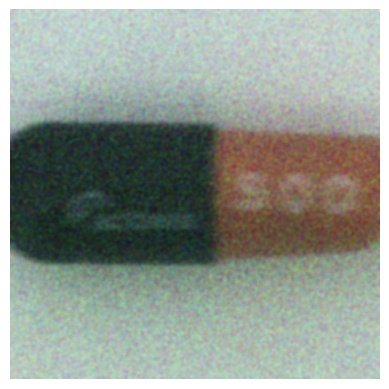

In [82]:
plt.imshow(img.permute(1,2,0))
plt.axis("off")

(-0.5, 699.5, 699.5, -0.5)

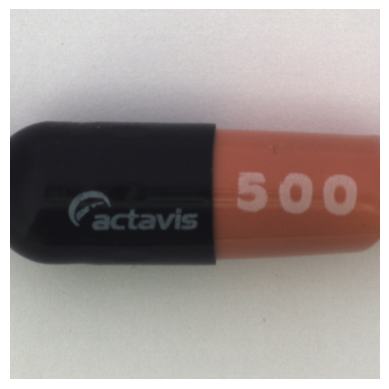

In [83]:
plt.imshow(label.permute(1,2,0))
plt.axis("off")

In [84]:
img = img.to(device)

In [85]:
DNet.eval()
with torch.no_grad():
  recon = DNet(img.unsqueeze(dim = 0))

In [86]:
recon = recon.to('cpu')
recon.shape

torch.Size([1, 3, 700, 700])

(-0.5, 699.5, 699.5, -0.5)

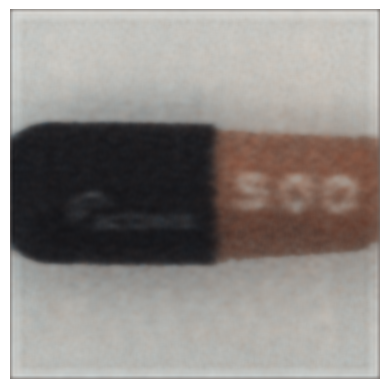

In [87]:
plt.imshow(recon.squeeze().permute(1,2,0).detach().numpy())
plt.axis("off")

In [96]:
#Calculating PSNR and SSIM on each test image
i = 1
psnr_list = []
ssim_list = []
for img,label in test_dataset:
  img = img.to(device)
  DNet.eval()
  with torch.no_grad():
      recon = DNet(img.unsqueeze(dim = 0))
  recon = recon.to('cpu')
  psnr = calculate_psnr(label,recon.squeeze())
  s = calculate_ssim(recon,label.unsqueeze(dim = 0))
  psnr_list.append(psnr)
  ssim_list.append(s)
  print(f" Image {i} PSNR: {psnr:.4f} || SSIM: {s:.4f}")
  i += 1
avg_psnr = sum(psnr_list)/len(psnr_list)
avg_ssim = sum(ssim_list)/len(ssim_list)
print(f"Average_PSNR = {avg_psnr:.4f} || Average SSIM = {avg_ssim:.4f}")

 Image 1 PSNR: 23.7885 || SSIM: 0.6105
 Image 2 PSNR: 21.1604 || SSIM: 0.8030
 Image 3 PSNR: 25.2608 || SSIM: 0.8688
 Image 4 PSNR: 24.9399 || SSIM: 0.8418
 Image 5 PSNR: 25.4233 || SSIM: 0.8501
 Image 6 PSNR: 23.8268 || SSIM: 0.5001
 Image 7 PSNR: 24.7366 || SSIM: 0.5256
 Image 8 PSNR: 18.5923 || SSIM: 0.3446
 Image 9 PSNR: 19.4333 || SSIM: 0.3981
 Image 10 PSNR: 22.1769 || SSIM: 0.7411
 Image 11 PSNR: 27.5851 || SSIM: 0.8484
 Image 12 PSNR: 29.6341 || SSIM: 0.6498
 Image 13 PSNR: 20.1482 || SSIM: 0.7775
 Image 14 PSNR: 25.4525 || SSIM: 0.7558
 Image 15 PSNR: 25.2841 || SSIM: 0.4835
 Image 16 PSNR: 19.5891 || SSIM: 0.7828
 Image 17 PSNR: 21.4034 || SSIM: 0.8303
 Image 18 PSNR: 23.5772 || SSIM: 0.7926
 Image 19 PSNR: 22.7777 || SSIM: 0.6219
 Image 20 PSNR: 26.1320 || SSIM: 0.8679
 Image 21 PSNR: 23.4573 || SSIM: 0.6475
 Image 22 PSNR: 25.3942 || SSIM: 0.8717
 Image 23 PSNR: 22.0473 || SSIM: 0.4560
 Image 24 PSNR: 23.9907 || SSIM: 0.6293
 Image 25 PSNR: 25.8985 || SSIM: 0.8192
 Image 26

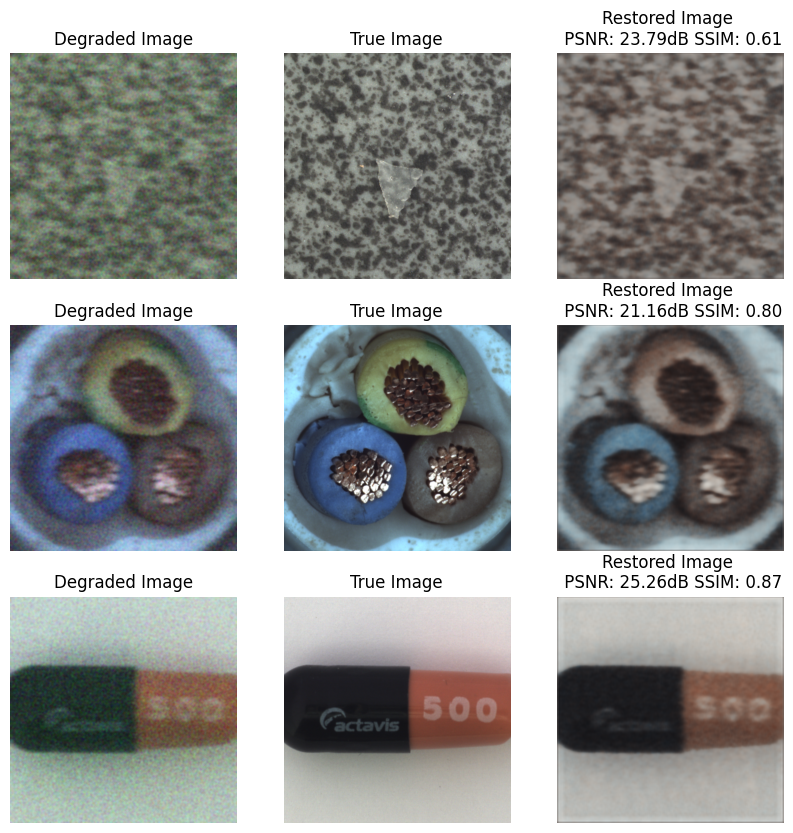

In [102]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10,10))
for j in range(0,3):
  img,label = test_dataset[j]
  img = img.to(device)
  DNet.eval()
  with torch.no_grad():
    recon = DNet(img.unsqueeze(dim = 0))
    recon = recon.to('cpu')
    plt.subplot(3,3,3*j + 1)
    plt.imshow(img.to('cpu').permute(1,2,0))
    plt.title("Degraded Image")
    plt.axis("off")

    plt.subplot(3,3,3*j + 2)
    plt.imshow(label.permute(1,2,0))
    plt.title("True Image")
    plt.axis("off")

    plt.subplot(3,3,3*j + 3)
    plt.imshow(recon.squeeze().permute(1,2,0).detach().numpy())
    plt.title(f"Restored Image \n PSNR: {psnr_list[j]:.2f}dB SSIM: {ssim_list[j]:.2f}")
    plt.axis("off")
plt.savefig("samples.png")
plt.show()

 Image 1psnr: PSNR: 23.7885 || SSIM: 0.6105
 Image 2psnr: PSNR: 21.1604 || SSIM: 0.8030
 Image 3psnr: PSNR: 25.2608 || SSIM: 0.8688
 Image 4psnr: PSNR: 24.9399 || SSIM: 0.8418
 Image 5psnr: PSNR: 25.4233 || SSIM: 0.8501
 Image 6psnr: PSNR: 23.8268 || SSIM: 0.5001
 Image 7psnr: PSNR: 24.7366 || SSIM: 0.5256
 Image 8psnr: PSNR: 18.5923 || SSIM: 0.3446
 Image 9psnr: PSNR: 19.4333 || SSIM: 0.3981
 Image 10psnr: PSNR: 22.1769 || SSIM: 0.7411
 Image 11psnr: PSNR: 27.5851 || SSIM: 0.8484
 Image 12psnr: PSNR: 29.6341 || SSIM: 0.6498
 Image 13psnr: PSNR: 20.1482 || SSIM: 0.7775
 Image 14psnr: PSNR: 25.4525 || SSIM: 0.7558
 Image 15psnr: PSNR: 25.2841 || SSIM: 0.4835
 Image 16psnr: PSNR: 19.5891 || SSIM: 0.7828
 Image 17psnr: PSNR: 21.4034 || SSIM: 0.8303
 Image 18psnr: PSNR: 23.5772 || SSIM: 0.7926
 Image 19psnr: PSNR: 22.7777 || SSIM: 0.6219
 Image 20psnr: PSNR: 26.1320 || SSIM: 0.8679
 Image 21psnr: PSNR: 23.4573 || SSIM: 0.6475
 Image 22psnr: PSNR: 25.3942 || SSIM: 0.8717
 Image 23psnr: PSNR

In [62]:
folder_path = r'/content/noisy_val_full'

image_files = sorted([f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))])
object_indices = {}

for index, image_name in enumerate(image_files):
    parts = image_name.split('_')
    if len(parts) > 1:
        object_type = parts[1]

        if object_type in object_indices:
            object_indices[object_type].append(index)
        else:
            object_indices[object_type] = [index]

for obj_type, indices in object_indices.items():
    print(f"Object type: {obj_type}, Indices: {indices}")


Object type: screw, Indices: [0, 44, 62, 75, 79, 80, 82, 85]
Object type: cable, Indices: [1, 6, 7, 8, 14, 15, 25, 28]
Object type: grid, Indices: [2, 3, 4, 11, 20]
Object type: pill, Indices: [5, 52, 53, 60, 61, 67, 68, 72, 81, 83, 84]
Object type: carpet, Indices: [9, 10, 33, 34, 58]
Object type: wood, Indices: [12, 18, 19, 26, 71]
Object type: zipper, Indices: [13, 24, 27, 36, 37, 56, 69]
Object type: tile, Indices: [16, 31, 35, 45, 54]
Object type: transistor, Indices: [17, 21, 22, 23]
Object type: hazelnut, Indices: [29, 46, 47, 48, 59]
Object type: leather, Indices: [30, 49, 50, 51, 65]
Object type: capsule, Indices: [32, 40, 57, 73, 76]
Object type: bottle, Indices: [38, 39, 41, 63, 64, 70]
Object type: metal, Indices: [42, 43, 66, 74, 77, 78]
Object type: toothbrush, Indices: [55, 86, 87]


In [69]:
#PSNR and SSIM for each object (individual)
for obj_type, indices in object_indices.items():
    obj_psnr = [psnr_list[i].item() for i in indices]
    obj_ssim = [ssim_list[i].item() for i in indices]
    print(f"{obj_type}: PSNR: {obj_psnr} || SSIM: {obj_ssim}")

screw: PSNR: [23.788450241088867, 27.519960403442383, 24.34319305419922, 23.712688446044922, 23.019277572631836, 23.67095184326172, 24.946552276611328, 21.986507415771484] || SSIM: [0.610456577986541, 0.8190983756048967, 0.7909709662668134, 0.8332304474448536, 0.5976793666924813, 0.8422980018134828, 0.6089508495193082, 0.5737733577280536]
cable: PSNR: [21.160400390625, 24.736618041992188, 18.592275619506836, 19.43330955505371, 25.28411865234375, 19.589078903198242, 21.51001739501953, 24.903518676757812] || SSIM: [0.803005599933576, 0.5255992017800286, 0.3446187850142384, 0.3981100869712912, 0.48351981869050303, 0.782788564287657, 0.7457535900606053, 0.5584505782588995]
grid: PSNR: [25.26080322265625, 24.93990707397461, 25.42327880859375, 29.634090423583984, 23.457305908203125] || SSIM: [0.8687786355025534, 0.8417922740652047, 0.8500683077059552, 0.6498416144500554, 0.6475222575300961]
pill: PSNR: [23.826780319213867, 24.693435668945312, 23.45482063293457, 21.71238136291504, 24.87367630

In [71]:
#Average PSNR and SSIM per class
avg_obj_psnr_list = []
avg_obj_ssim_list = []
obj_list = []
for obj_type, indices in object_indices.items():
    obj_list.append(obj_type)
    obj_psnr = [psnr_list[i].item() for i in indices]
    obj_ssim = [ssim_list[i].item() for i in indices]
    avg_obj_psnr = sum(obj_psnr)/len(obj_psnr)
    avg_obj_psnr_list.append(avg_obj_psnr)
    avg_obj_ssim_list.append(avg_obj_ssim)
    avg_obj_ssim = sum(obj_ssim)/len(obj_ssim)
    print(f"{obj_type}: Average_PSNR: {avg_obj_psnr:.4f} || Average_SSIM: {avg_obj_ssim:.4f}")

screw: Average_PSNR: 24.1234 || Average_SSIM: 0.7096
cable: Average_PSNR: 21.9012 || Average_SSIM: 0.5802
grid: Average_PSNR: 25.7431 || Average_SSIM: 0.7716
pill: Average_PSNR: 25.0706 || Average_SSIM: 0.6634
carpet: Average_PSNR: 23.6160 || Average_SSIM: 0.7211
wood: Average_PSNR: 23.8797 || Average_SSIM: 0.7412
zipper: Average_PSNR: 24.3066 || Average_SSIM: 0.7610
tile: Average_PSNR: 23.5117 || Average_SSIM: 0.7027
transistor: Average_PSNR: 23.7523 || Average_SSIM: 0.6874
hazelnut: Average_PSNR: 23.7402 || Average_SSIM: 0.7786
leather: Average_PSNR: 24.8797 || Average_SSIM: 0.8044
capsule: Average_PSNR: 25.1296 || Average_SSIM: 0.8006
bottle: Average_PSNR: 23.3519 || Average_SSIM: 0.6764
metal: Average_PSNR: 24.3996 || Average_SSIM: 0.6504
toothbrush: Average_PSNR: 22.9898 || Average_SSIM: 0.6892


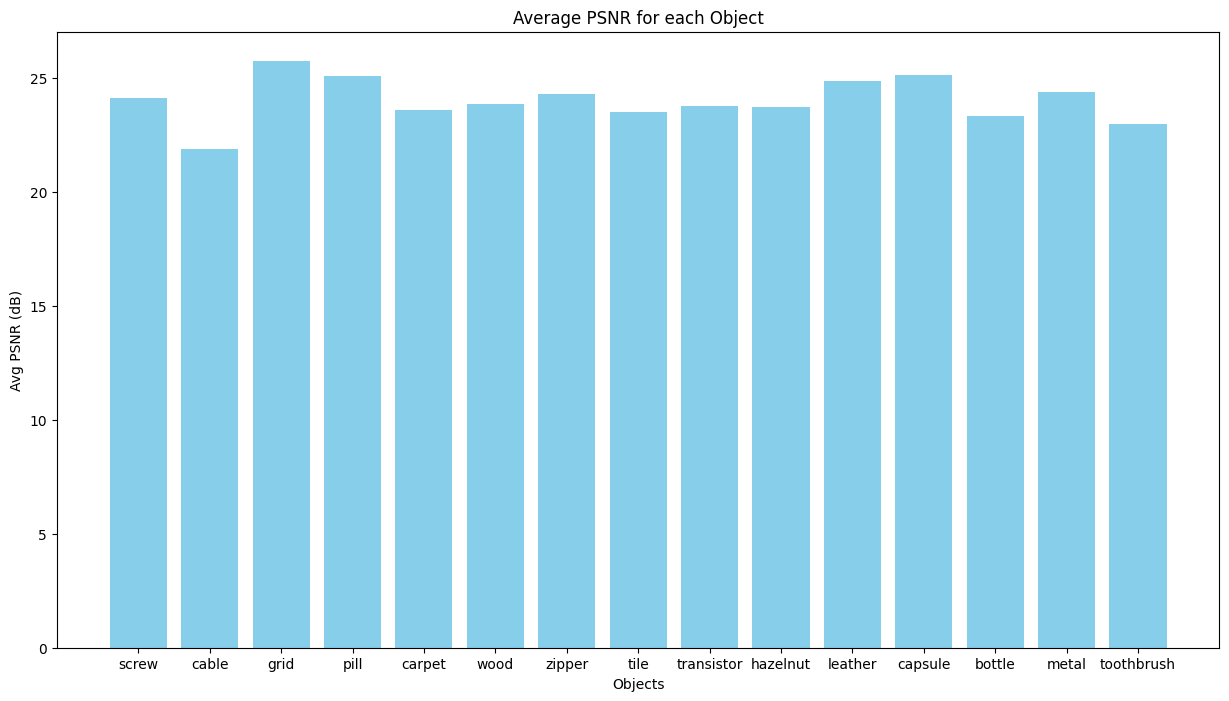

In [103]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))
plt.bar(obj_list, avg_obj_psnr_list, color='skyblue')
plt.xlabel('Objects')
plt.ylabel('Avg PSNR (dB)')
plt.title('Average PSNR for each Object')
plt.savefig("psnrvals.png")


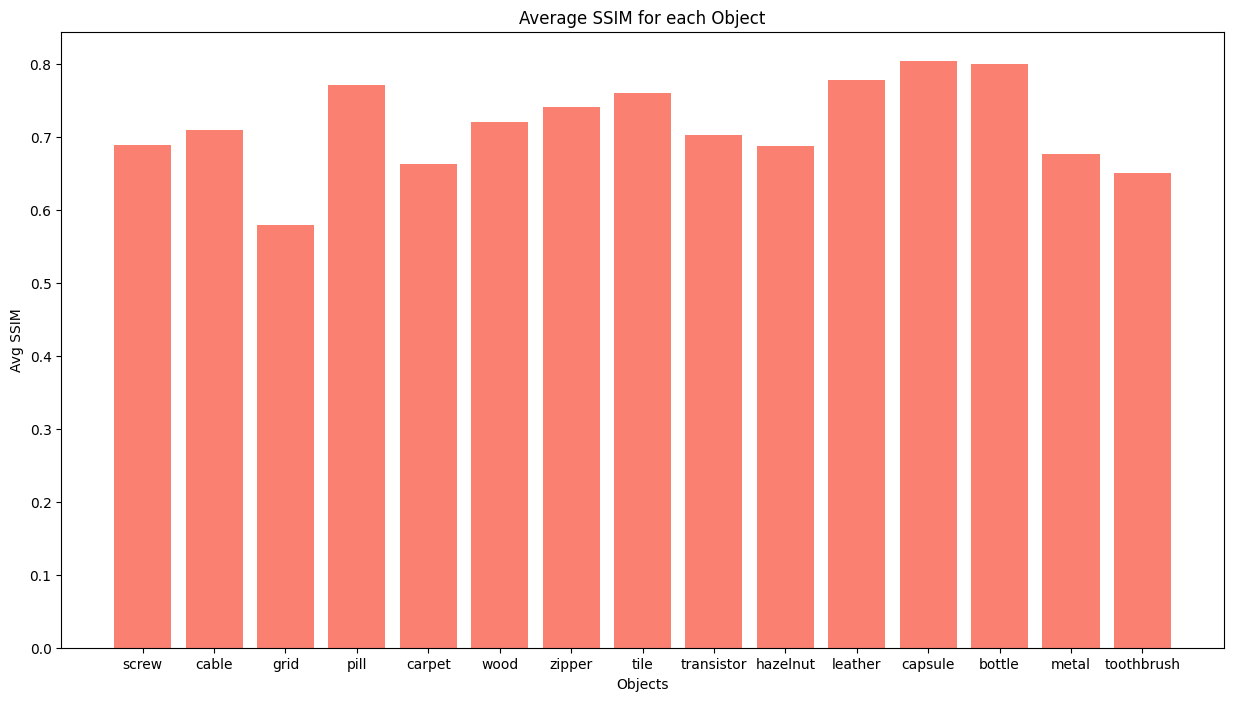

In [101]:
plt.figure(figsize=(15, 8))
plt.bar(obj_list, avg_obj_ssim_list, color='salmon')
plt.xlabel('Objects')
plt.ylabel('Avg SSIM')
plt.title('Average SSIM for each Object')
plt.savefig("ssimvals.png")
plt.show()